<a href="https://colab.research.google.com/github/jkranyak/birdscompetitionkaggle/blob/main/bird_competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Index:
# 1. Install Necessary Libraries
# 2. Set Up Directory Structure for Processed Data
# 3. Define Spectrogram Conversion Function
# 4. Preprocess Audio Files into Spectrograms
# 5. Data Augmentation (Optional)
# 6. Split Dataset
# 7. Prepare Model Input
# 8. Define Model Architecture
# 9. Compile Model
# 10. Prepare for Training (Callbacks)
# 11. Train Model
# 12. Evaluate Model
# 13. Submit to Kaggle

## Step 1: Install Necessary Libraries


In [1]:
!pip install librosa soundfile tensorflow scikit-learn numpy pandas matplotlib seaborn tqdm
!pip install audiomentations


In [40]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, LSTM, TimeDistributed, Dense, Dropout, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from keras.utils import Sequence
from keras.preprocessing.image import load_img, img_to_array

import os
import librosa
import soundfile as sf
import torch
import torch.nn as nn

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

import joblib
from multiprocessing import Pool
from scipy import signal
from scipy.io import wavfile
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift


In [3]:
if tf.test.gpu_device_name():
    print(f"Default GPU Device: {tf.test.gpu_device_name()}")
else:
    print("Please install GPU version of TF")
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Default GPU Device: /device:GPU:0
Thu Apr 11 17:40:21 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   48C    P0              17W /  72W |    191MiB / 23034MiB |      2%      Default |
|                                         |                      |                  N/A |
+---------------------------------

In [41]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Streaming output truncated to the last 5000 lines.
/kaggle/input/birdclef-2024/train_audio/woosan/XC240476.ogg
/kaggle/input/birdclef-2024/train_audio/woosan/XC742928.ogg
/kaggle/input/birdclef-2024/train_audio/woosan/XC820544.ogg
/kaggle/input/birdclef-2024/train_audio/woosan/XC827124.ogg
/kaggle/input/birdclef-2024/train_audio/woosan/XC800004.ogg
/kaggle/input/birdclef-2024/train_audio/woosan/XC182905.ogg
/kaggle/input/birdclef-2024/train_audio/woosan/XC768514.ogg
/kaggle/input/birdclef-2024/train_audio/woosan/XC685750.ogg
/kaggle/input/birdclef-2024/train_audio/woosan/XC653281.ogg
/kaggle/input/birdclef-2024/train_audio/woosan/XC687190.ogg
/kaggle/input/birdclef-2024/train_audio/woosan/XC145349.ogg
/kaggle/input/birdclef-2024/train_audio/woosan/XC565297.ogg
/kaggle/input/birdclef-2024/train_audio/woosan/XC741701.ogg
/kaggle/input/birdclef-2024/train_audio/woosan/XC629318.ogg
/kaggle/input/birdclef-2024/train_audio/woosan/XC687200.ogg
/kaggle/input/birdclef-2024/train_audio/woosan/XC

#Data Setup

---

###Download and unpack dataset


###Set up directory structure for processed data

In [75]:
# Define output directories
output_directories = ['processed_data', 'models', 'submissions', 'visualizations']
base_working_dir = '/kaggle/working/'

# Creating subdirectories
for directory in output_directories:
    path = os.path.join(base_working_dir, directory)
    os.makedirs(path, exist_ok=True)
    print(f"Created directory: {path}")

# Input data paths
train_audio_path = "/kaggle/input/birdclef-2024/train_audio"
unlabeled_soundscapes_path = "/kaggle/input/birdclef-2024/unlabeled_soundscapes"
train_metadata_csv_path = "/kaggle/input/birdclef-2024/train_metadata.csv"
taxonomy_csv_path = "/kaggle/input/birdclef-2024/eBird_Taxonomy_v2021.csv"
sample_submission_csv_path = "/kaggle/input/birdclef-2024/sample_submission.csv"
test_soundscapes_path = "/kaggle/input/birdclef-2024/test_soundscapes"


Created directory: /kaggle/working/processed_data
Created directory: /kaggle/working/models
Created directory: /kaggle/working/submissions
Created directory: /kaggle/working/visualizations


Convert audio to spectrograms


---


augment for processing later


In [ ]:
def advanced_audio_augmentation(audio_signal, sr):
    # Time stretching
    time_stretch_factor = np.random.uniform(0.9, 1.1)
    audio_signal = librosa.effects.time_stretch(audio_signal, rate=time_stretch_factor)

    # Pitch shifting with the correct argument usage
    n_steps = np.random.randint(-2, 3)  # Randomly shift pitch between -2 to 2 semitones
    audio_signal = librosa.effects.pitch_shift(audio_signal, sr=sr, n_steps=n_steps)

    # Adding noise
    noise_level = np.random.uniform(0.001, 0.005)
    noise = np.random.normal(0, noise_level, len(audio_signal))
    audio_signal += noise

    return audio_signal

def create_and_augment_spectrogram(audio_path, save_path):
    y, sr = librosa.load(audio_path, sr=None)
    y_augmented = advanced_audio_augmentation(y, sr)
    S = librosa.feature.melspectrogram(y=y_augmented, sr=sr)
    S_DB = librosa.power_to_db(S, ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Augmented Mel-frequency spectrogram')
    plt.tight_layout()
    plt.savefig(save_path.replace('.png', '_augmented_spectrogram.png'))  # Append '_augmented' before '.png'
    plt.close()

def process_all_audio_files(base_audio_dir, processed_data_dir):
    """
    Process all .ogg audio files in the given directory and its subdirectories,
    apply augmentations, convert them into spectrograms, and save those spectrograms.
    """
    # Ensure the directory for processed data exists
    os.makedirs(processed_data_dir, exist_ok=True)

    # Traverse subdirectories to find all .ogg files
    for subdir, dirs, files in os.walk(base_audio_dir):
        for file in files:
            if file.endswith('.ogg'):
                audio_path = os.path.join(subdir, file)
                filename = os.path.basename(audio_path)
                save_path = os.path.join(processed_data_dir, f"{os.path.splitext(filename)[0]}_augmented_spectrogram.png")
                create_and_augment_spectrogram(audio_path, save_path)

# Example usage
base_audio_dir = '/kaggle/input/birdclef-2024/train_audio'  # Path to your audio files
processed_data_dir = '/kaggle/working/processed_data'  # Where to save spectrograms
process_all_audio_files(base_audio_dir, processed_data_dir)

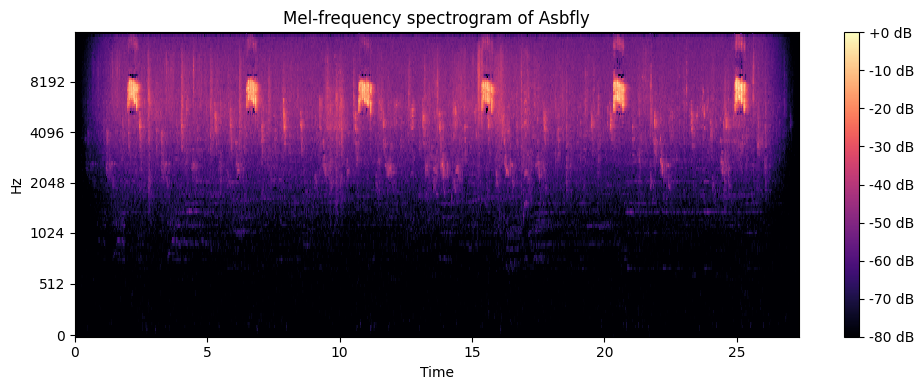

In [77]:
# Visualize the spectrogram of the processed sample
sample_audio_file = '/kaggle/input/birdclef-2024/train_audio/asbfly/XC134896.ogg'  # Example path, adjust as needed

# Loading and processing the audio file to create a spectrogram
y, sr = librosa.load(sample_audio_file, sr=None)
S = librosa.feature.melspectrogram(y=y, sr=sr)
S_DB = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram of Asbfly')
plt.tight_layout()
plt.show()

lets check out the metadata

In [78]:
train_metadata = pd.read_csv(train_metadata_csv_path)
taxonomy_data = pd.read_csv(taxonomy_csv_path)
sample_submission = pd.read_csv(sample_submission_csv_path)

print("Train Metadata - First 5 Rows:")
print(train_metadata.head())
print("\nTaxonomy Data - First 5 Rows:")
print(taxonomy_data.head())
print("\nSample Submission - First 5 Rows:")
print(sample_submission.head())

Train Metadata - First 5 Rows:
  primary_label secondary_labels      type  latitude  longitude  \
0        asbfly               []  ['call']   39.2297   118.1987   
1        asbfly               []  ['song']   51.4030   104.6401   
2        asbfly               []  ['song']   36.3319   127.3555   
3        asbfly               []  ['call']   21.1697    70.6005   
4        asbfly               []  ['call']   15.5442    73.7733   

      scientific_name             common_name  \
0  Muscicapa dauurica  Asian Brown Flycatcher   
1  Muscicapa dauurica  Asian Brown Flycatcher   
2  Muscicapa dauurica  Asian Brown Flycatcher   
3  Muscicapa dauurica  Asian Brown Flycatcher   
4  Muscicapa dauurica  Asian Brown Flycatcher   

                              author  \
0                     Matt Slaymaker   
1                   Magnus Hellström   
2                      Stuart Fisher   
3                          vir joshi   
4  Albert Lastukhin & Sergei Karpeev   

                              

Normalize and standardize features

In [79]:
# Filter metadata to include relevant columns
filtered_metadata_df = train_metadata[['primary_label', 'latitude', 'longitude', 'url', 'filename']]

# Extract features to be normalized and standardized
features_to_scale = ['latitude', 'longitude']

# Initialize StandardScaler
scaler = StandardScaler()

# Fit scaler to the features and transform them
filtered_metadata_df.loc[:, features_to_scale] = scaler.fit_transform(filtered_metadata_df.loc[:, features_to_scale])

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder to the primary_label column and transform it
filtered_metadata_df['primary_label'] = label_encoder.fit_transform(filtered_metadata_df['primary_label']) + 1

# Print the mapping between original labels and encoded values
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Encoding Mapping:")
print(label_mapping)

# Print the first few rows of the DataFrame
print("Processed DataFrame:")
print(filtered_metadata_df.head())

Label Encoding Mapping:
{'asbfly': 0, 'ashdro1': 1, 'ashpri1': 2, 'ashwoo2': 3, 'asikoe2': 4, 'asiope1': 5, 'aspfly1': 6, 'aspswi1': 7, 'barfly1': 8, 'barswa': 9, 'bcnher': 10, 'bkcbul1': 11, 'bkrfla1': 12, 'bkskit1': 13, 'bkwsti': 14, 'bladro1': 15, 'blaeag1': 16, 'blakit1': 17, 'blhori1': 18, 'blnmon1': 19, 'blrwar1': 20, 'bncwoo3': 21, 'brakit1': 22, 'brasta1': 23, 'brcful1': 24, 'brfowl1': 25, 'brnhao1': 26, 'brnshr': 27, 'brodro1': 28, 'brwjac1': 29, 'brwowl1': 30, 'btbeat1': 31, 'bwfshr1': 32, 'categr': 33, 'chbeat1': 34, 'cohcuc1': 35, 'comfla1': 36, 'comgre': 37, 'comior1': 38, 'comkin1': 39, 'commoo3': 40, 'commyn': 41, 'compea': 42, 'comros': 43, 'comsan': 44, 'comtai1': 45, 'copbar1': 46, 'crbsun2': 47, 'cregos1': 48, 'crfbar1': 49, 'crseag1': 50, 'dafbab1': 51, 'darter2': 52, 'eaywag1': 53, 'emedov2': 54, 'eucdov': 55, 'eurbla2': 56, 'eurcoo': 57, 'forwag1': 58, 'gargan': 59, 'gloibi': 60, 'goflea1': 61, 'graher1': 62, 'grbeat1': 63, 'grecou1': 64, 'greegr': 65, 'grefla1': 

<ipython-input-79-e198a3342fc6>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_metadata_df['primary_label'] = label_encoder.fit_transform(filtered_metadata_df['primary_label']) + 1


extra augmentation, lets go ahead and add in a function to add in some background noise to the training set and pitch shifting.

Model Development
Define the CRNN model arhitecture
Compile the model with appropriate loss function and optimizer

In [80]:
def build_crnn_model(input_shape=(128, 128, 1), num_metadata_features=2, time_steps=1):
    # Adjust input shape to include time dimension
    adjusted_input_shape = (time_steps,) + input_shape  # Now it's (time_steps, 128, 128, 1)

    # Spectrogram input branch
    spectrogram_input = Input(shape=adjusted_input_shape, name='spectrogram_input')
    x = TimeDistributed(Conv2D(32, kernel_size=(3, 3), activation='relu'))(spectrogram_input)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    x = TimeDistributed(Conv2D(64, (3, 3), activation='relu'))(x)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    x = TimeDistributed(Flatten())(x)

    # LSTM layer to handle temporal features
    x = LSTM(64, return_sequences=False)(x)

    # Metadata input branch
    metadata_input = Input(shape=(num_metadata_features,), name='metadata_input')
    metadata_dense = Dense(32, activation='relu')(metadata_input)

    # Combining both branches
    combined = concatenate([x, metadata_dense])
    combined = Dense(64, activation='relu')(combined)
    combined = Dropout(0.5)(combined)
    outputs = Dense(1, activation='sigmoid')(combined)

    model = Model(inputs=[spectrogram_input, metadata_input], outputs=outputs)

    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [81]:
filtered_metadata_df['filename'] = filtered_metadata_df['filename'].apply(
    lambda x: os.path.join(processed_data_dir, x.replace('.ogg', '_augmented_spectrogram.png'))
)

<ipython-input-81-f0ec78cccac6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_metadata_df['filename'] = filtered_metadata_df['filename'].apply(


In [82]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, file_paths, labels, batch_size=32, dim=(128, 128), n_channels=1, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.file_paths = file_paths
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.file_paths) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_paths = [self.file_paths[k] for k in indexes]
        X, y = self.__data_generation(batch_paths)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.file_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, file_paths_temp):
        'Generates data containing batch_size samples'
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
        actual_batch_size = 0  # To handle cases where files might be missing

        for i, file_path in enumerate(file_paths_temp):
          if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            continue  # Skip this file if not found
          img = load_img(file_path, target_size=self.dim, color_mode='grayscale')
          img = img_to_array(img) / 255.0
          X[actual_batch_size,] = img
          y[actual_batch_size] = self.labels[i]
          actual_batch_size += 1

        return X[:actual_batch_size], np.array(y[:actual_batch_size])


In [83]:
import os

# Verify files exist
processed_data_dir = '/kaggle/working/processed_data'
all_files = os.listdir(processed_data_dir)

if not all_files:
    print("No files in the directory.")
else:
    print(f"Number of files in the directory: {len(all_files)}")
    print("Sample files:", all_files[:5])  # Print first 5 file names to check


Number of files in the directory: 106
Sample files: ['XC610735_spectrogram.png', 'XC610734_spectrogram.png', 'XC684073_spectrogram.png', 'XC687955_spectrogram.png', 'XC164848_spectrogram.png']


###Model Training
Since we are using images, we will need to set up datagenerators and then we can Split data into training and validation sets


In [84]:
missing_files = [f for f in filtered_metadata_df['filename'] if not os.path.exists(f)]
if missing_files:
    print(f"Missing files: {missing_files[:5]}")  # Print first few missing files
else:
    print("All files accounted for.")

Missing files: ['/kaggle/working/processed_data/asbfly/XC134896_augmented_spectrogram.png', '/kaggle/working/processed_data/asbfly/XC164848_augmented_spectrogram.png', '/kaggle/working/processed_data/asbfly/XC175797_augmented_spectrogram.png', '/kaggle/working/processed_data/asbfly/XC207738_augmented_spectrogram.png', '/kaggle/working/processed_data/asbfly/XC209218_augmented_spectrogram.png']


In [85]:
# Generate the model
model = build_crnn_model(input_shape=(128, 128, 1))

# Split data into training and validation sets correctly referencing 'filename' and 'primary_label'
X = filtered_metadata_df['filename'].values
y = filtered_metadata_df['primary_label'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Use updated parameters
params = {'dim': (128, 128), 'batch_size': 32, 'n_channels': 1, 'shuffle': True}

training_generator = DataGenerator(X_train, y_train, **params)
validation_generator = DataGenerator(X_val, y_val, **params)

# Model training
history = model.fit(training_generator, validation_data=validation_generator, epochs=100, callbacks=callbacks, verbose=1)


File not found: /kaggle/working/processed_data/houspa/XC644556_augmented_spectrogram.png
File not found: /kaggle/working/processed_data/bkwsti/XC789681_augmented_spectrogram.png
File not found: /kaggle/working/processed_data/whbsho3/XC856377_augmented_spectrogram.png
File not found: /kaggle/working/processed_data/oripip1/XC700805_augmented_spectrogram.png
File not found: /kaggle/working/processed_data/blakit1/XC323761_augmented_spectrogram.png
File not found: /kaggle/working/processed_data/comros/XC377328_augmented_spectrogram.png
File not found: /kaggle/working/processed_data/woosan/XC733183_augmented_spectrogram.png
File not found: /kaggle/working/processed_data/zitcis1/XC337545_augmented_spectrogram.png
File not found: /kaggle/working/processed_data/indrol2/XC442343_augmented_spectrogram.png
File not found: /kaggle/working/processed_data/bkwsti/XC260281_augmented_spectrogram.png
File not found: /kaggle/working/processed_data/grywag/XC602711_augmented_spectrogram.png
File not found: 

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_6" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, None, None, None) dtype=float32>]


###Callbacks

In [14]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(base_working_dir, 'models/best_model.h5'),
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]


###build & train the model

In [23]:
# Model training with properly defined callbacks and using the DataGenerator
history = model.fit(
    training_generator,
    validation_data=validation_generator,
    epochs=100,  # Adjust epochs and batch_size as needed
    callbacks=callbacks,
    verbose=1
)

File not found: /kaggle/working/processed_data/XC531014_augmented_spectrogram.png
File not found: /kaggle/working/processed_data/XC854612_augmented_spectrogram.png
File not found: /kaggle/working/processed_data/XC418170_augmented_spectrogram.png
File not found: /kaggle/working/processed_data/XC509475_augmented_spectrogram.png
File not found: /kaggle/working/processed_data/XC632947_augmented_spectrogram.png
File not found: /kaggle/working/processed_data/XC484953_augmented_spectrogram.png
File not found: /kaggle/working/processed_data/XC144879_augmented_spectrogram.png
File not found: /kaggle/working/processed_data/XC533882_augmented_spectrogram.png
File not found: /kaggle/working/processed_data/XC666155_augmented_spectrogram.png
File not found: /kaggle/working/processed_data/XC426165_augmented_spectrogram.png
File not found: /kaggle/working/processed_data/XC376639_augmented_spectrogram.png
File not found: /kaggle/working/processed_data/XC736464_augmented_spectrogram.png
File not found: 

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_1" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, None, None, None) dtype=float32>]


valuation and Testing
Evaluate the model on the test set or soundscapes
Apply any post-processing needed for predictions
Analyze model performance metrics

In [ ]:

# After training, summarize the model
model.summary()


# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

Optimization and Tuning
Fine-tune model parameters
Experiment with different architectures or features
Re-train and evaluate the model

submission
